Введение

Это введение в объяснение моделей машинного обучения с помощью значений Шепли. Значения Шепли - это широко используемый подход из теории кооперативных игр, обладающий желаемыми свойствами. Данное руководство предназначено для того, чтобы помочь сформировать четкое понимание того, как вычислять и интерпретировать объяснения моделей машинного обучения, основанные на значениях Шепли. Мы будем использовать практический подход, применяя пакет `shap` на языке Python для объяснения все более сложных моделей. Это живой документ, который служит введением в пакет `shap` на Python.


Ключевые концепции SHAP:

Значения Шепли: SHAP вычисляет значение Шепли для каждого признака, представляющее его вклад в предсказание модели. Значение Шепли признака - это среднее предельное увеличение точности предсказания, которое включает этот признак, по всем возможным подмножествам других признаков.  

Аддитивное объяснение: SHAP основан на идее аддитивного объяснения, где объяснение модели представляет собой сумму вкладов каждого признака. Это позволяет SHAP обеспечить как локальные объяснения для отдельных предсказаний, так и глобальное понимание важности признаков.  

Свойства объяснений: Объяснения SHAP обладают несколькими желательными свойствами, включая локальную точность (объяснения соответствуют фактическому выходу модели для данного экземпляра), отсутствие смещения (вклады признаков в среднем равны разнице между фактическим предсказанием и средним предсказанием) и согласованность (увеличение значения признака никогда не должно уменьшать его вклад).  

Методы аппроксимации: Точный расчет значений Шепли может быть вычислительно сложным, особенно для моделей с большим количеством признаков. SHAP предлагает несколько методов аппроксимации, таких как Kernel SHAP (для любой модели), Linear SHAP (для линейных моделей), Tree SHAP (для деревьев решений и ансамблей) и Deep SHAP (для нейронных сетей), чтобы эффективно оценивать значения Шепли.

<a id="linear_regression"></a>

## Объяснение модели линейной регрессии

Прежде чем использовать значения Шепли для объяснения сложных моделей, полезно понять, как они работают для простых моделей. Одним из самых простых типов моделей является стандартная линейная регрессия, поэтому ниже мы обучаем модель линейной регрессии на [наборе данных о жилье в Калифорнии](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html). Этот набор данных состоит из 20 640 блоков домов по всей Калифорнии в 1990 году, где наша цель - предсказать натуральный логарифм медианной цены дома по 8 различным признакам:

1. MedInc - медианный доход в группе блоков
2. HouseAge - медианный возраст домов в группе блоков
3. AveRooms - среднее количество комнат на домохозяйство
4. AveBedrms - среднее количество спален на домохозяйство
5. Population - население группы блоков
6. AveOccup - среднее количество членов домохозяйства
7. Latitude - широта группы блоков
8. Longitude - долгота группы блоков

In [38]:
!pip install shap interpret

In [39]:
import sklearn
import shap

X, y = shap.datasets.california(n_points=1000)

X100 = shap.utils.sample(X, 100)

model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

LinearRegression()

### Исследование коэффициентов модели

Наиболее распространенным способом понимания линейной модели является исследование коэффициентов, полученных для каждого признака. Эти коэффициенты показывают нам, насколько сильно изменяется выход модели при изменении каждого из входных признаков:


In [40]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(5))

Model coefficients:

MedInc = 0.42563
HouseAge = 0.01033
AveRooms = -0.1161
AveBedrms = 0.66385
Population = 3e-05
AveOccup = -0.26096
Latitude = -0.46734
Longitude = -0.46272


Хотя коэффициенты отлично подходят для того, чтобы рассказать нам, что произойдет, когда мы изменим значение входного признака, сами по себе они не являются хорошим способом измерения общей важности признака. Это связано с тем, что значение каждого коэффициента зависит от масштаба входных признаков. Если, например, мы будем измерять возраст дома в минутах, а не в годах, то коэффициенты для признака HouseAge станут равны 0,0115 / (365∗24∗60) = 2,18e-8. Ясно, что количество лет с момента постройки дома не важнее, чем количество минут, но значение его коэффициента намного больше. Это означает, что величина коэффициента не обязательно является хорошей мерой важности признака в линейной модели.

### Более полная картина с использованием графиков частичной зависимости

Чтобы понять важность признака в модели, необходимо понять как то, как изменение этого признака влияет на выход модели, так и распределение значений этого признака. Чтобы визуализировать это для линейной модели, мы можем построить классический график частичной зависимости и показать распределение значений признака в виде гистограммы на оси x:

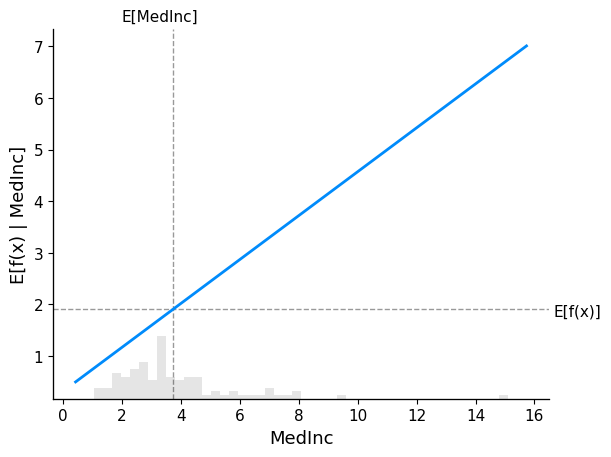

In [41]:
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

Серая горизонтальная линия на графике выше представляет ожидаемое значение модели при применении к набору данных о жилье в Калифорнии. Вертикальная серая линия представляет среднее значение признака медианного дохода. Обратите внимание, что синяя линия графика частичной зависимости (которая является средним значением выхода модели, когда мы фиксируем признак медианного дохода на заданном значении) всегда проходит через пересечение двух серых линий ожидаемого значения. Мы можем рассматривать эту точку пересечения как "центр" графика частичной зависимости относительно распределения данных. Влияние этого центрирования станет ясным, когда мы перейдем к значениям Шепли далее.

### Чтение значений SHAP из графиков частичной зависимости

Основная идея объяснений моделей машинного обучения, основанных на значениях Шепли, заключается в использовании результатов справедливого распределения из теории кооперативных игр для распределения заслуги за выход модели $f(x)$ между ее входными признаками<!--[cite]-->. Чтобы связать теорию игр с моделями машинного обучения, необходимо как сопоставить входные признаки модели с игроками в игре, так и сопоставить функцию модели с правилами игры. Поскольку в теории игр игрок может присоединиться или не присоединиться к игре, нам нужен способ, позволяющий признаку "присоединиться" или "не присоединиться" к модели. Наиболее распространенный способ определить, что означает для признака "присоединиться" к модели, - это сказать, что признак "присоединился к модели", когда мы знаем значение этого признака, и он не присоединился к модели, когда мы не знаем значение этого признака. Чтобы оценить существующую модель $f$, когда только подмножество $S$ признаков являются частью модели, мы интегрируем остальные признаки, используя формулировку условного ожидаемого значения. Эта формулировка может принимать две формы:

$$
E[f(X) \mid X_S = x_S]
$$

<center>или</center>

$$
E[f(X) \mid do(X_S = x_S)]
$$

В первой форме мы знаем значения признаков в S, потому что мы их *наблюдаем*. Во второй форме мы знаем значения признаков в S, потому что мы их *устанавливаем*. В целом, вторая форма обычно предпочтительнее, как потому, что она говорит нам, как модель будет вести себя, если мы вмешаемся и изменим ее входные данные, так и потому, что ее намного проще вычислить. <!--Для гораздо более глубокого обсуждения различий между этими двумя формулировками см. отдельную статью о [причинной и наблюдаемой важности признаков]() [TODO].--> В этом руководстве мы сосредоточимся исключительно на второй формулировке. Мы также будем использовать более конкретный термин "значения SHAP" для обозначения значений Шепли, применяемых к функции условного ожидания модели машинного обучения.

Значения SHAP могут быть очень сложными для вычисления (в общем случае они NP-сложны), но линейные модели настолько просты, что мы можем считывать значения SHAP прямо с графика частичной зависимости. Когда мы объясняем прогноз $f(x)$, значение SHAP для конкретного признака $i$ - это просто разница между ожидаемым выходом модели и графиком частичной зависимости при значении признака $x_i$:

ExactExplainer explainer: 1001it [00:10,  3.73it/s]                         


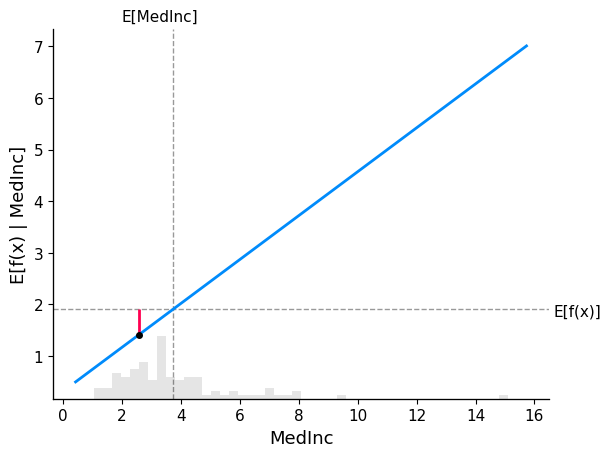

In [42]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

Тесная связь между классическим графиком частичной зависимости и значениями SHAP означает, что если мы построим график значения SHAP для конкретного признака по всему набору данных, мы точно проследим центрированную по среднему версию графика частичной зависимости для этого признака:

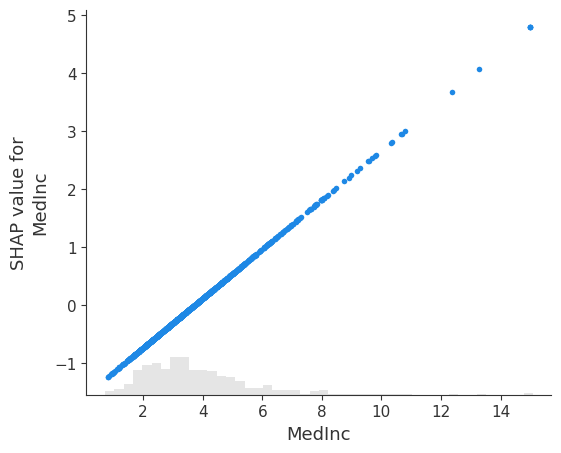

In [ ]:
shap.plots.scatter(shap_values[:, "MedInc"])


### Аддитивная природа значений Шепли

Одно из фундаментальных свойств значений Шепли заключается в том, что они всегда суммируются до разницы между исходом игры, когда присутствуют все игроки, и исходом игры, когда игроков нет. Для моделей машинного обучения это означает, что значения SHAP всех входных признаков всегда будут суммироваться до разницы между базовым (ожидаемым) выходом модели и текущим выходом модели для объясняемого прогноза. Самый простой способ увидеть это - через водопадный график, который начинается с нашего фонового предварительного ожидания цены дома $E[f(X)]$, а затем добавляет признаки один за другим, пока мы не достигнем текущего выхода модели $f(x)$:

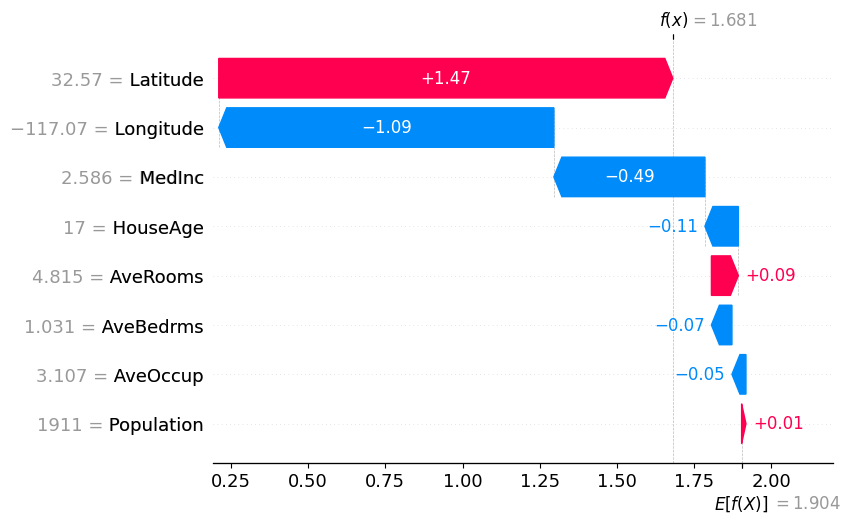

In [ ]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

## Объяснение аддитивной регрессионной модели

<a id="additive_regression"></a>

Причина, по которой графики частичной зависимости линейных моделей имеют такую тесную связь со значениями SHAP, заключается в том, что каждый признак в модели обрабатывается независимо от всех остальных признаков (эффекты просто складываются). Мы можем сохранить эту аддитивную природу, ослабив требование линейности прямых линий. Это приводит к хорошо известному классу обобщенных аддитивных моделей (GAM). Хотя есть много способов обучения моделей этого типа (например, установка модели XGBoost на глубину 1), мы будем использовать объяснимые бустинги InterpretML, которые специально разработаны для этого.

ExactExplainer explainer: 1001it [00:13, 19.87it/s]                          


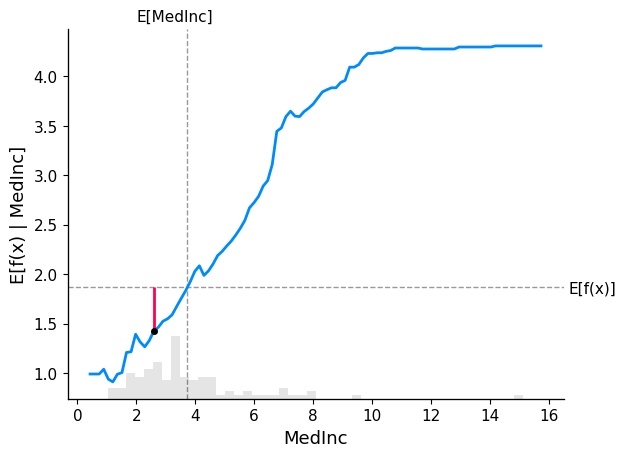

In [ ]:
# fit a GAM model to the data
import interpret.glassbox

model_ebm = interpret.glassbox.ExplainableBoostingRegressor(interactions=0)
model_ebm.fit(X, y)

# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X100)
shap_values_ebm = explainer_ebm(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig, ax = shap.partial_dependence_plot(
    "MedInc",
    model_ebm.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_ebm[sample_ind : sample_ind + 1, :],
)

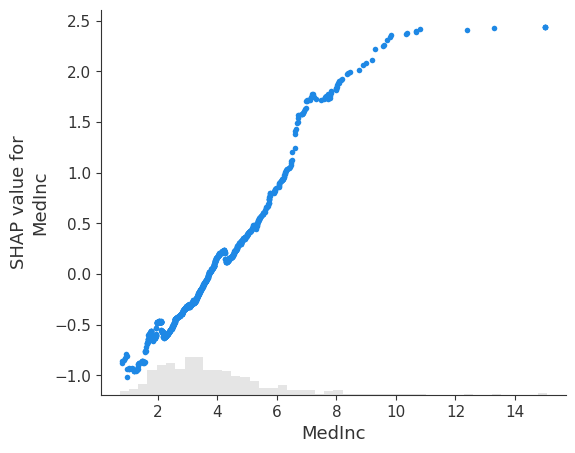

In [ ]:
shap.plots.scatter(shap_values_ebm[:, "MedInc"])

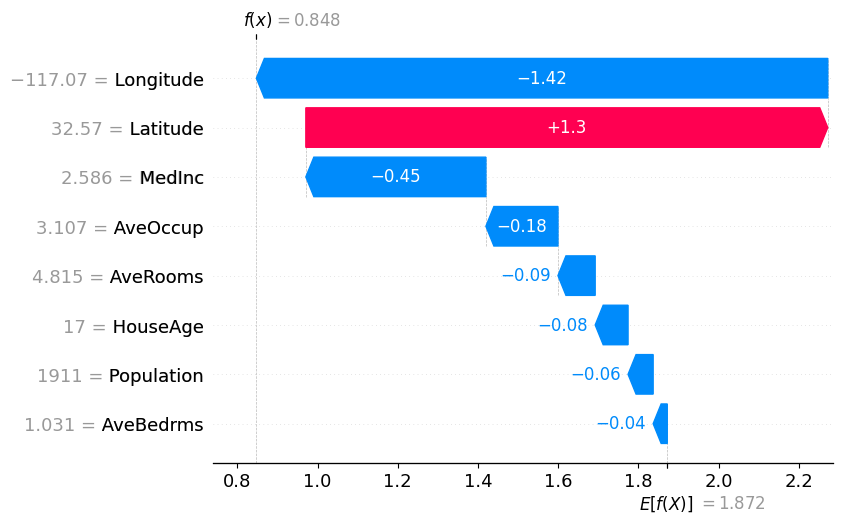

In [ ]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values_ebm[sample_ind])

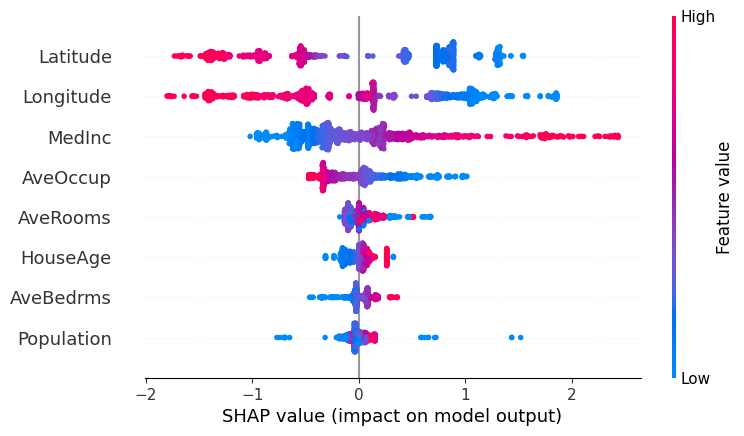

In [ ]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.beeswarm(shap_values_ebm)

<a id="boosted_tree"></a>
## Объяснение неаддитивной модели бустинга для регрессии

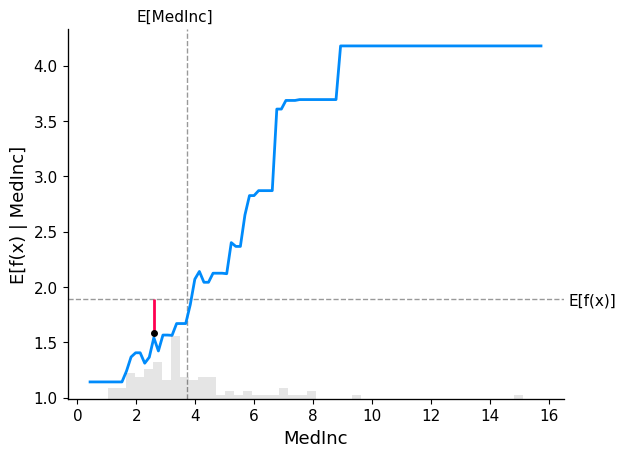

In [ ]:
# train XGBoost model
import xgboost

model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig, ax = shap.partial_dependence_plot(
    "MedInc",
    model_xgb.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_xgb[sample_ind : sample_ind + 1, :],
)

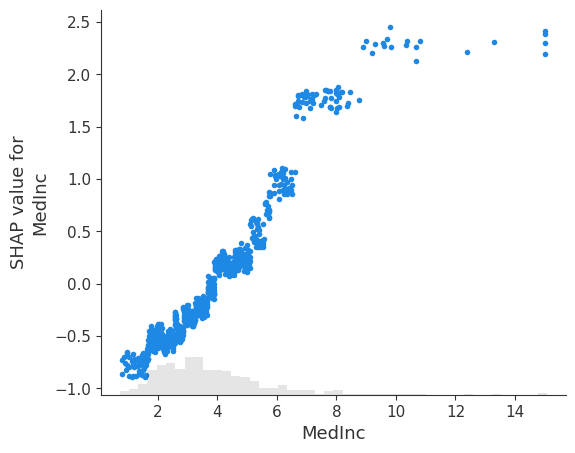

In [ ]:
shap.plots.scatter(shap_values_xgb[:, "MedInc"])

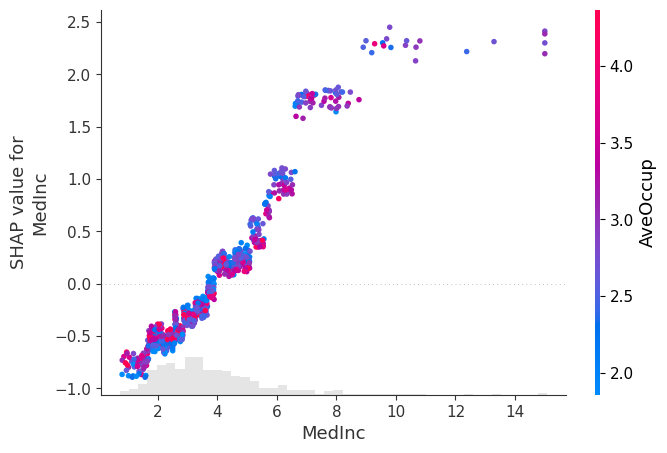

In [ ]:
shap.plots.scatter(shap_values_xgb[:, "MedInc"], color=shap_values)

<a id="logistic_regression"></a>
## Объяснение логистической регрессии

Adult Census Income - Набор данных содержит информацию о различных демографических и социально-экономических характеристиках взрослых людей, таких как возраст, образование, занятость, семейное положение и доход. Целевая переменная указывает, зарабатывает ли человек более 50 000 долларов в год или нет.


**Данные включают следующие столбцы:**
- ``Age`` (число с плавающей запятой)
  Возраст в годах.

- ``Workclass`` (категория)
  Тип занятости.

- ``fnlwgt`` (число с плавающей запятой)
  Окончательный вес; количество единиц в целевой совокупности, которые представляет запись.

- ``Education`` (категория)
  Наивысший достигнутый уровень образования.

- ``Education-Num`` (число с плавающей запятой)
  Числовое представление уровня образования.

- ``Marital Status`` (категория)
  Семейное положение человека.

- ``Occupation`` (категория)
  Тип занятия.

- ``Relationship`` (категория)
  Состояние отношений.

- ``Race`` (категория)
  Этническая принадлежность человека.

- ``Sex`` (категория)
  Пол человека.

- ``Capital Gain`` (число с плавающей запятой)
  Зафиксированные доходы от прироста капитала.

- ``Capital Loss`` (число с плавающей запятой)
  Зафиксированные потери капитала.

- ``Hours per week`` (число с плавающей запятой)
  Количество отработанных часов в неделю.

- ``Country`` (категория)
  Страна происхождения.

- ``Target`` (категория)
  Бинарная целевая переменная, указывающая, зарабатывает ли человек больше 50 тысяч.

In [43]:
# a classic adult census dataset price dataset
X_adult, y_adult = shap.datasets.adult()

# a simple linear logistic model
model_adult = sklearn.linear_model.LogisticRegression(max_iter=10000)
model_adult.fit(X_adult, y_adult)


def model_adult_proba(x):
    return model_adult.predict_proba(x)[:, 1]


def model_adult_log_odds(x):
    p = model_adult.predict_log_proba(x)
    return p[:, 1] - p[:, 0]

Обратите внимание, что объяснение вероятности модели линейной логистической регрессии не является линейным по входным данным.

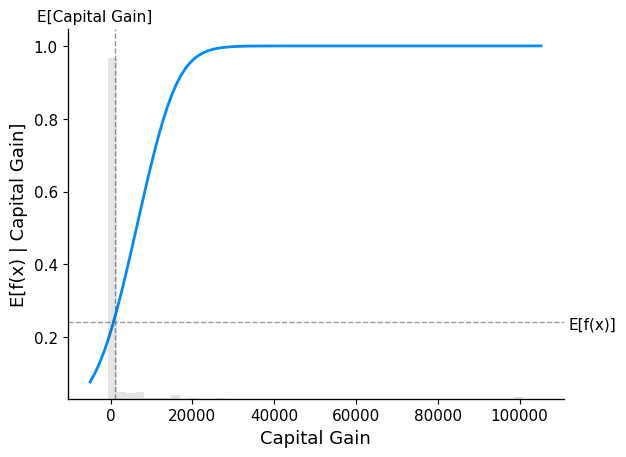

In [44]:
# make a standard partial dependence plot
sample_ind = 18
fig, ax = shap.partial_dependence_plot(
    "Capital Gain",
    model_adult_proba,
    X_adult,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
)

Если мы используем SHAP для объяснения вероятности модели линейной логистической регрессии, мы увидим сильные эффекты взаимодействия. Это связано с тем, что модель линейной логистической регрессии НЕ является аддитивной в вероятностном пространстве.

In [45]:
# compute the SHAP values for the linear model
background_adult = shap.maskers.Independent(X_adult, max_samples=100)
explainer = shap.Explainer(model_adult_proba, background_adult)
shap_values_adult = explainer(X_adult[:1000])

PermutationExplainer explainer: 1001it [01:18, 11.08it/s]                          


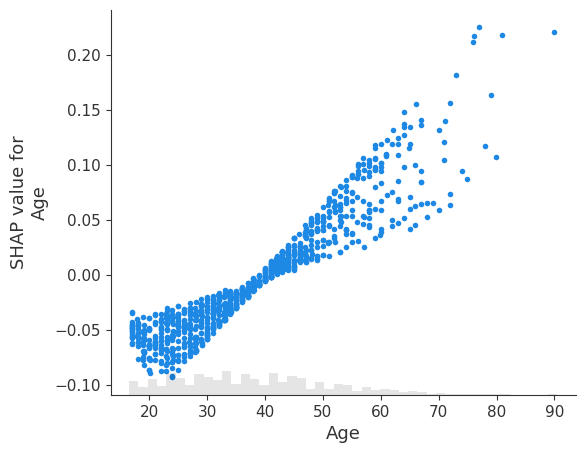

In [46]:
shap.plots.scatter(shap_values_adult[:, "Age"])

Если вместо этого мы объясним выходные данные модели, то увидим идеальную линейную связь между входными и выходными данными модели. Важно помнить, каковы единицы модели, которую вы объясняете, и что объяснение различных результатов модели может привести к совершенно разным взглядам на поведение модели.

In [47]:
# compute the SHAP values for the linear model
explainer_log_odds = shap.Explainer(model_adult_log_odds, background_adult)
shap_values_adult_log_odds = explainer_log_odds(X_adult[:1000])

PermutationExplainer explainer:  86%|████████▌ | 859/1000 [01:12<00:14,  9.92it/s]


KeyboardInterrupt: 

In [ ]:
shap.plots.scatter(shap_values_adult_log_odds[:, "Age"])

In [ ]:
# make a standard partial dependence plot
sample_ind = 18
fig, ax = shap.partial_dependence_plot(
    "Age",
    model_adult_log_odds,
    X_adult,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
)

<a id="non_additive_logistic"></a>
## Объяснение неаддитивной модели бустинга для классификации

In [48]:
# train XGBoost model
model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(
    X_adult, y_adult * 1
)

# compute SHAP values
explainer = shap.Explainer(model, background_adult)
shap_values = explainer(X_adult)

# set a display version of the data to use for plotting (has string values)
shap_values.display_data = shap.datasets.adult(display=True)[0].values

 98%|===================| 31881/32561 [00:23<00:00]       

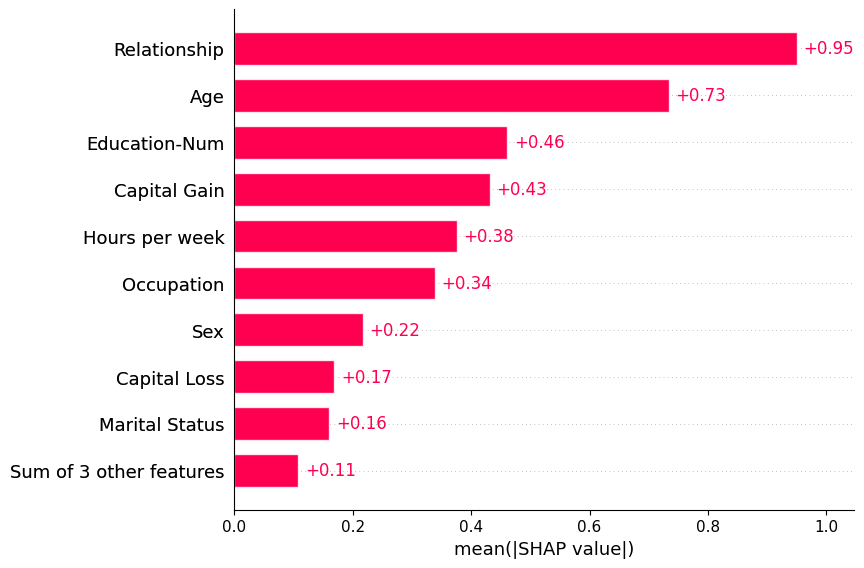

In [49]:
shap.plots.bar(shap_values)

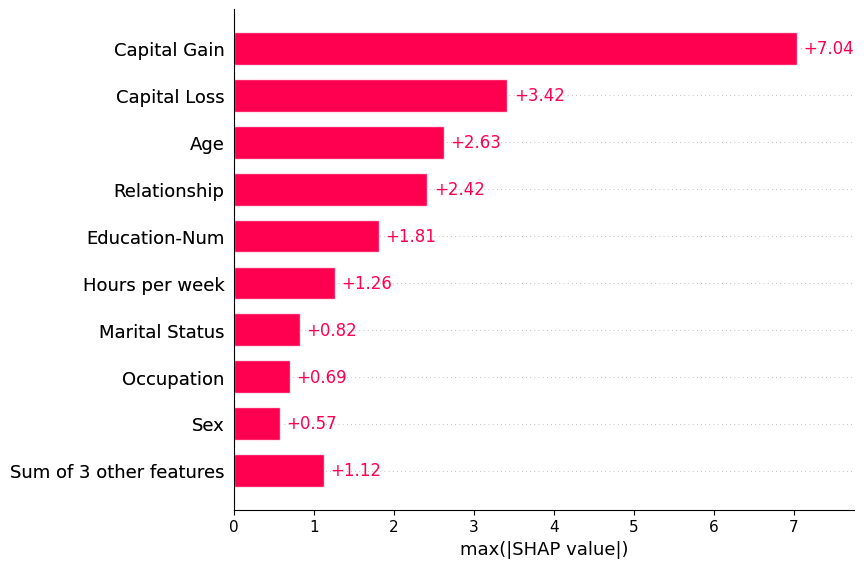

In [50]:
shap.plots.bar(shap_values.abs.max(0))

Если мы готовы иметь дело с немного большей сложностью, мы можем использовать график beeswarm для суммирования всего распределения значений SHAP для каждого объекта.

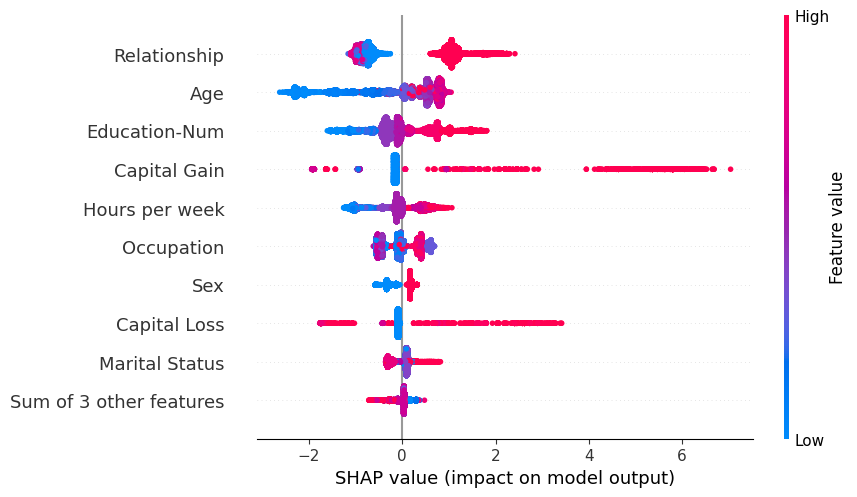

In [51]:
shap.plots.beeswarm(shap_values)

Взяв абсолютное значение и используя сплошной цвет, мы получаем компромисс между сложностью гистограммы и beeswarm. Обратите внимание, что приведенные выше гистограммы представляют собой просто сводную статистику значений, показанных на графиках beeswarm ниже.

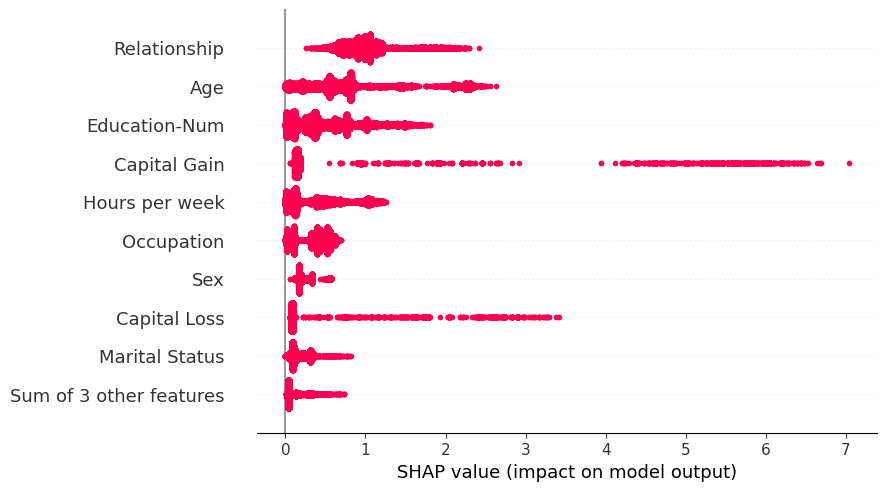

In [52]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

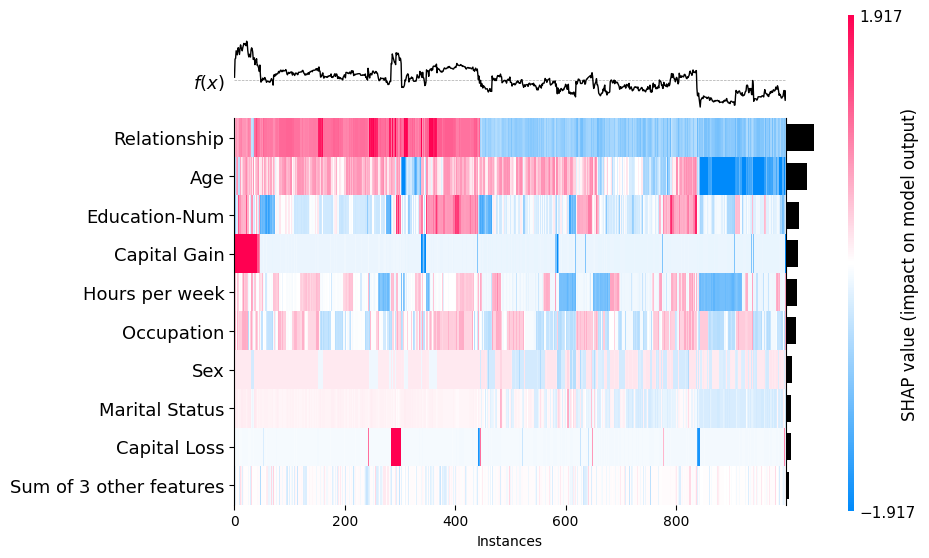

<Axes: xlabel='Instances'>

In [53]:
shap.plots.heatmap(shap_values[:1000])

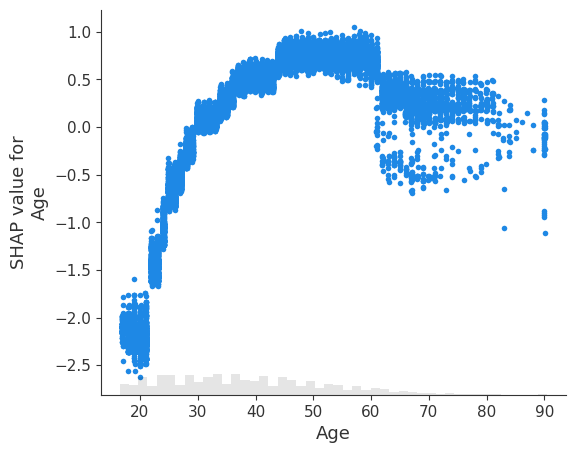

In [54]:
shap.plots.scatter(shap_values[:, "Age"])

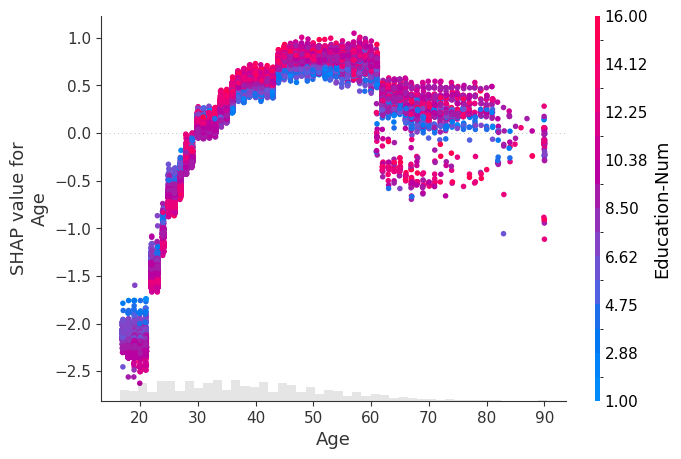

In [55]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values)

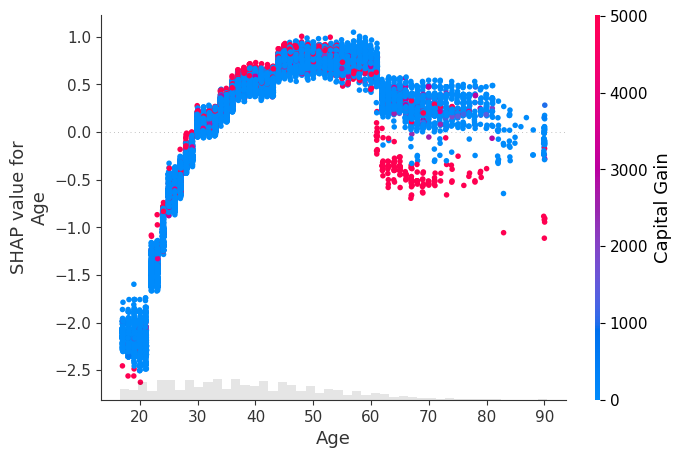

In [56]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values[:, "Capital Gain"])

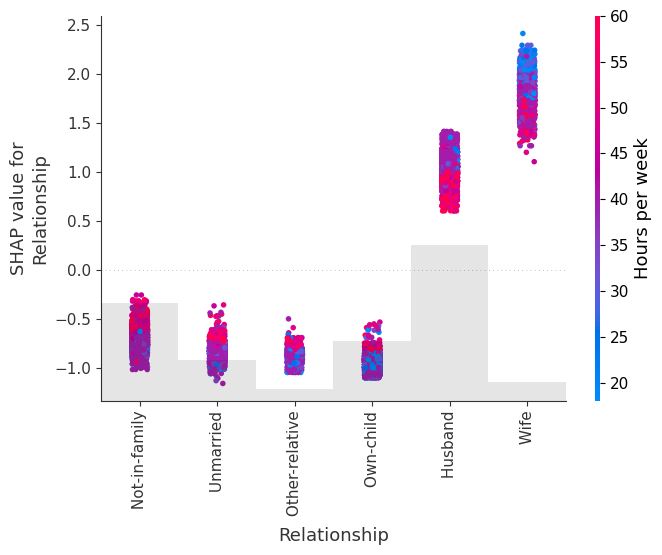

In [57]:
shap.plots.scatter(shap_values[:, "Relationship"], color=shap_values)

<a id="correlated_features"></a>
## Работа с коррелирующими функциями

In [58]:
clustering = shap.utils.hclust(X_adult, y_adult)

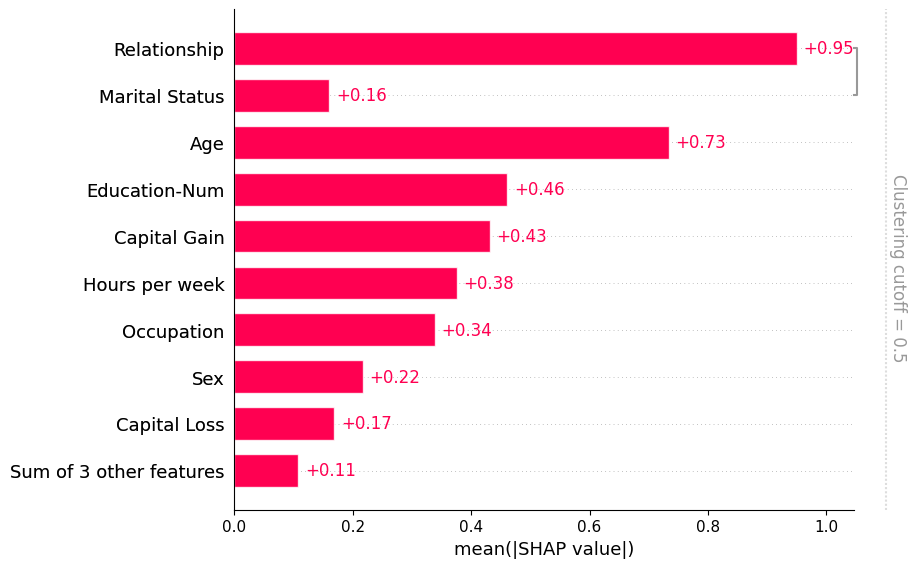

In [59]:
shap.plots.bar(shap_values, clustering=clustering)

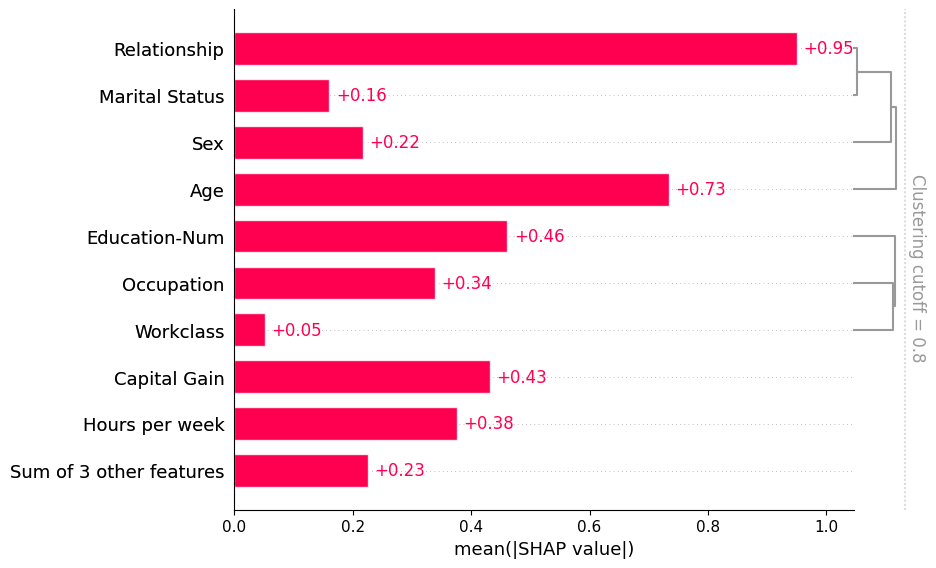

In [60]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.8)

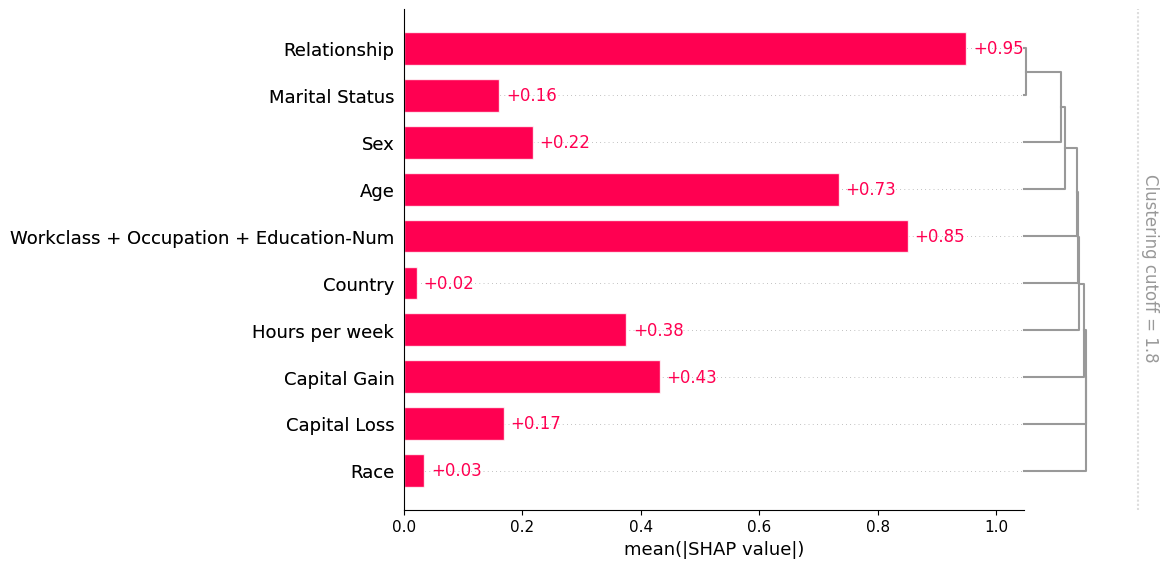

In [61]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=1.8)